In [1]:
%pylab notebook 

Populating the interactive namespace from numpy and matplotlib


In [5]:
from pleque.io import _geqdsk as eqdsktool 
from pleque.io.readers import read_geqdsk
from pleque.utils.plotting import *
from pleque import Equilibrium
from pleque_test.testing_utils import get_test_equilibria_filenames, load_testing_equilibrium



In [6]:
mpl.get_configdir()

'C:\\Users\\lukas\\.matplotlib'

In [7]:
print('\n'.join(plt.style.available))
plt.style.use('seaborn-talk')
#plt.style.use(['default', 'presentation'])
#plt.style.use(['default'])
plt.style.reload_library()

bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
seaborn-bright
seaborn-colorblind
seaborn-dark-palette
seaborn-dark
seaborn-darkgrid
seaborn-deep
seaborn-muted
seaborn-notebook
seaborn-paper
seaborn-pastel
seaborn-poster
seaborn-talk
seaborn-ticks
seaborn-white
seaborn-whitegrid
seaborn
Solarize_Light2
tableau-colorblind10
_classic_test


In [ ]:
%load_ext autoreload
%autoreload 2

In [9]:
def save_it(name, v=1):
    if False:
        file_dir = '/compass/home/kripner/konference/2018_PhdEvent/fig/'
        savefig(file_dir +  name +'_v' + str(v) + '.png', transparent=True)
        savefig(file_dir +  name +'_v' + str(v) + '.pdf', transparent=True)
    

In [10]:
gfiles = get_test_equilibria_filenames()
gfiles

['C:\\Users\\lukas\\Documents\\Projects\\pleque\\pleque_test\\test_files\\baseline_eqdsk',
 'C:\\Users\\lukas\\Documents\\Projects\\pleque\\pleque_test\\test_files\\scenario_1_baseline_upward_eqdsk',
 'C:\\Users\\lukas\\Documents\\Projects\\pleque\\pleque_test\\test_files\\DoubleNull_eqdsk',
 'C:\\Users\\lukas\\Documents\\Projects\\pleque\\pleque_test\\test_files\\g13127.1050',
 'C:\\Users\\lukas\\Documents\\Projects\\pleque\\pleque_test\\test_files\\_Equidisk_File__15MA_T_ped_4.5keV_513x51_44WYKU_v1_0.txt',
 'C:\\Users\\lukas\\Documents\\Projects\\pleque\\pleque_test\\test_files\\14068@1130_2kA_modified_triang.gfile',
 'C:\\Users\\lukas\\Documents\\Projects\\pleque\\pleque_test\\test_files\\g15349.1120']

  nx = 65, ny = 129
197 1
--- No limiter specified. The IBA v3.1 limiter will be used.
---------------------------------
Equilibrium module initialization
---------------------------------
--- Generate 2D spline ---
--- Looking for extremes ---


<IPython.core.display.Javascript object>


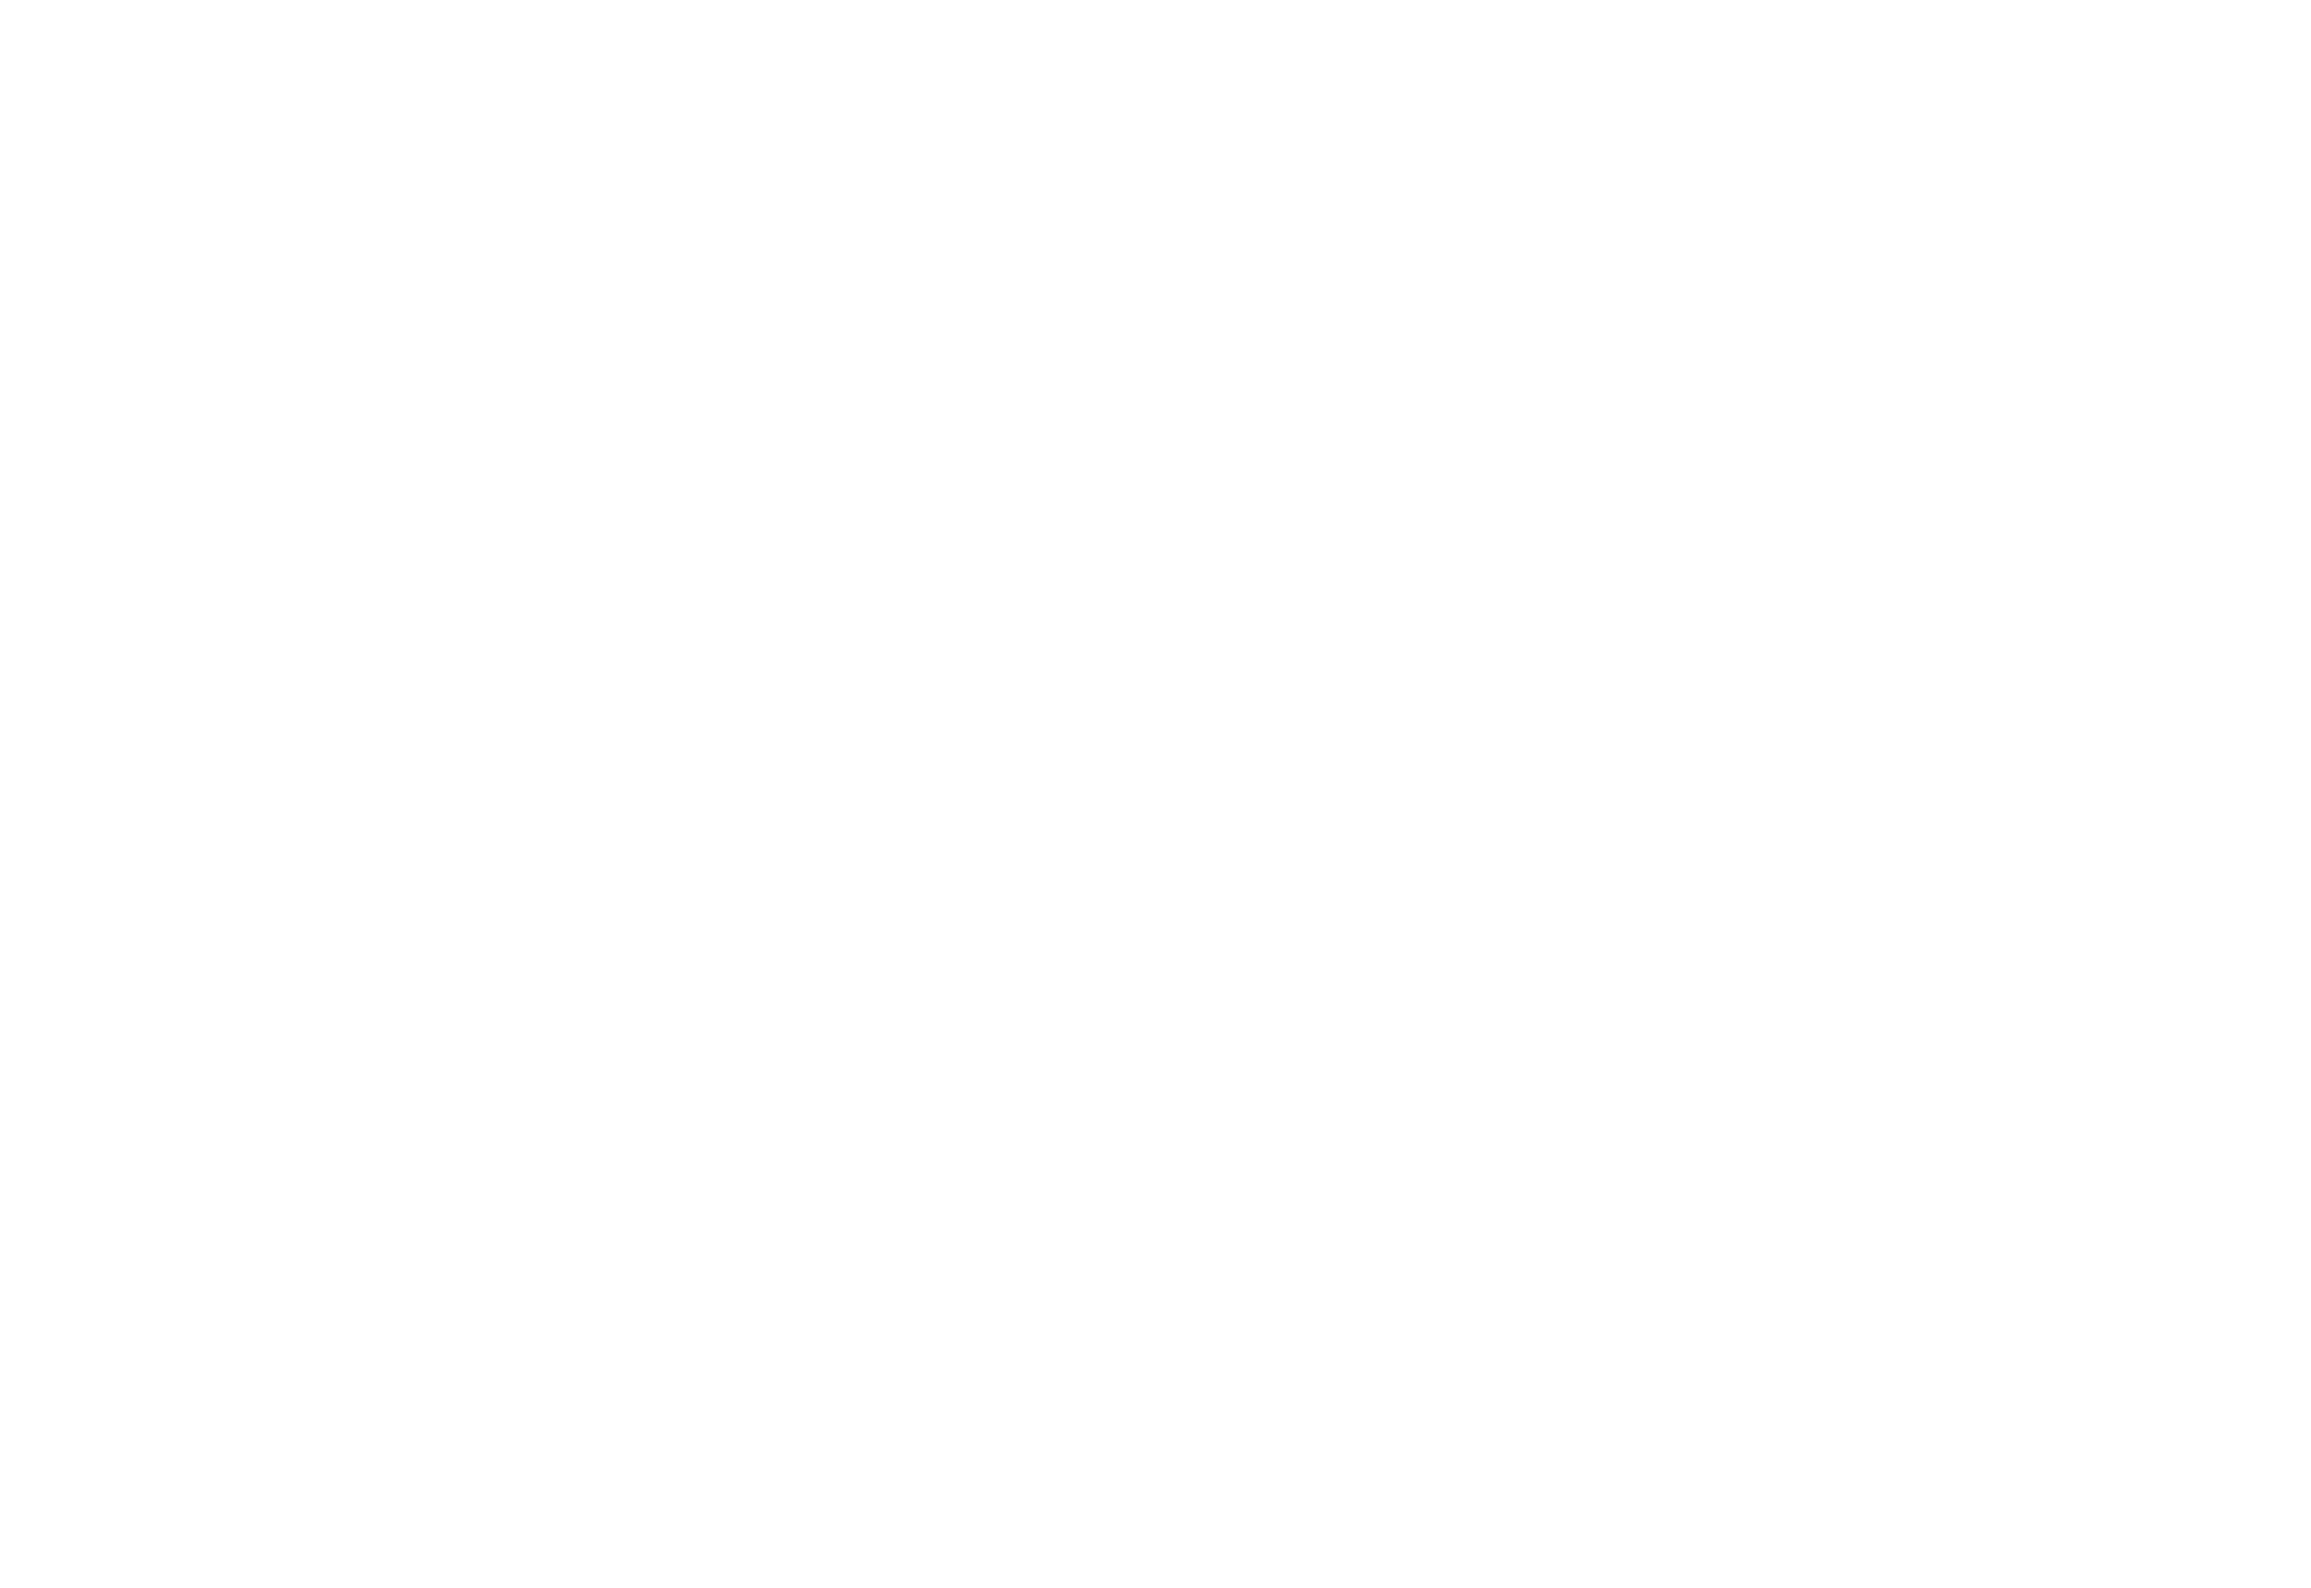

>>> lower x-point configuration found
--- Generate 1D splines ---
--- Mapping midplane to psi_n ---
--- Mapping pressure and f func to psi_n ---


In [11]:
eq = load_testing_equilibrium()

In [ ]:
g = eq.grid(resolution=[1e-3, 1e-3])
g.psi.shape

In [ ]:
# first three files are fiesta and may cause some troubles
Npl = 6

eq = read_eqdsk(gfiles[Npl])

eq_iter = read_eqdsk(gfiles[4])
with open(gfiles[Npl], 'r') as f:
    eq_efit = eqdsktool.read(f)
eq_efit.keys()

plt.figure()
eq._plot_overview()
save_it('overview', 1)

In [ ]:
plt.figure()
eq._plot_overview()
plot_extremes(eq, markeredgewidth=2)
plt.tight_layout()
save_it('overview_with_extremes')


In [ ]:
#gfile

r_axis = np.linspace(eq_efit["rleft"], eq_efit["rleft"] + eq_efit["rdim"], eq_efit["nx"])
z_axis = np.linspace(eq_efit["zmid"] - eq_efit["zdim"] / 2, eq_efit["zmid"] + eq_efit["zdim"] / 2, eq_efit["ny"])

plt.figure()
ax = plt.gca()
ax.plot(eq_efit['rlim'], eq_efit['zlim'], color='k', lw=2)
#ax.plot(eq_efit['rbdry'], eq_efit['zbdry'], 'C1--', lw=2)
ax.contour(r_axis, z_axis, eq_efit['psi'].T, 20)
ax.contour(r_axis, z_axis, eq_efit['psi'].T, [eq_efit['sibdry']])
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')
ax.set_xlim(0.4, 0.54)
ax.set_ylim(-.38, -.28)

save_it('gfile', 2)

In [ ]:
plt.figure()
ax = plt.gca()
ax.plot(eq_efit['rlim'], eq_efit['zlim'], color='k', lw=2)
ax.plot(eq_efit['rbdry'], eq_efit['zbdry'], 'C0-.', lw=2)
ax.contour(r_axis, z_axis, eq_efit['psi'].T, [eq_efit['sibdry']], colors='C0')

eq.lcfs.plot(color='C1', ls='--')
ax.plot(eq._x_point[0], eq._x_point[1], 'C1+', lw=3)

ax.set_aspect('equal')
#ax.set_xlim((5.06, 5.09))
#ax.set_ylim((-3.45, -3.43))


## q-profile

In [ ]:

# q profiles

coords = eq.coordinates(psi_n = np.linspace(0, 1, 201, endpoint=True))

surf_psin = linspace(0.95, 1, 121, endpoint=False) 
surfs = [eq._flux_surface(psi_n=psi_n)[0] for psi_n in surf_psin]

surf_psin = [np.mean(s.psi_n) for s in surfs]
surf_q    = np.array([np.asscalar(s.eval_q) for s in surfs])
surf_q2    = np.array([np.asscalar(s.get_eval_q('trapz')) for s in surfs])
surf_q3    = np.array([np.asscalar(s.get_eval_q('simps')) for s in surfs])

qpsi = eq_efit['qpsi']
psi_n_1 = np.linspace(0, 1, len(qpsi), endpoint=True)
psi_n_2 = np.linspace(0, 1, len(qpsi), endpoint=False)
    
    
plt.figure()

plt.plot(psi_n_1, np.abs(eq_efit['qpsi']), 'x', label='eqdsk 1')
#plt.plot(psi_n_2, np.abs(eq_efit['qpsi']), '--', label='eqdsk 2')
plt.plot(coords.psi_n, np.abs(eq.q(coords)), '--', label=r'pleque: Equilibrium $q$')
plt.plot(surf_psin, np.abs(surf_q), '-', label=r'pleque: eval_q')
#plt.plot(surf_psin, np.abs(surf_q2), '--', label=r'pleque: eval_q2')
#plt.plot(surf_psin, np.abs(surf_q3), '--', label=r'pleque: eval_q3')
plt.xlim((0.5, 1.05))
plt.xlabel(r'$\psi_\mathrm{N}$')
plt.ylabel(r'$q$')
           
plt.axvline(1, ls='--', color='k')
save_it('q_profile')


plt.legend()

plt.figure()
plt.plot(surf_psin, (surf_q-surf_q2)**2, label='q vs q2')
plt.plot(surf_psin, (surf_q-surf_q3)**2, label='q vs q3')
plt.plot(surf_psin, (surf_q2-surf_q3)**2, label='q2 vs q3')
plt.legend()



## Plotting 2d maps of various quiantities

In [ ]:
def plot_2d(R, Z, data, *args, title=None):
    
    rlim = [np.min(eq.first_wall.R), np.max(eq.first_wall.R)]
    zlim = [np.min(eq.first_wall.Z), np.max(eq.first_wall.Z)]

    size = rlim[1] - rlim[0]
    rlim[0] -= size / 12
    rlim[1] += size / 12

    size = zlim[1] - zlim[0]
    zlim[0] -= size / 12
    zlim[1] += size / 12
    
    plt.figure()    
    ax = plt.gca()
    
    ax.set_xlim(rlim)
    ax.set_ylim(zlim)
    
    ax.plot(eq.lcfs.R, eq.lcfs.Z, color='k', ls='--', lw=2)
    ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-', lw=2)
    ax.set_xlabel('R [m]')
    ax.set_ylabel('Z [m]')
    

    ax.set_aspect('equal')
    
    cl = ax.contour(R, Z, data, *args)
    
    if title is not None:
        ax.set_title(title)
        
    return cl

In [ ]:
eq = eq_iter
grid = eq.grid((200,300),dim='size')

plot_2d(grid.R, grid.Z, grid.psi, 20, title=r'$\psi$')
save_it('tok_psi', 2)
plot_2d(grid.R, grid.Z, eq.B_pol(grid), 20, title=r'$B_\mathrm{p}$')
save_it('tok_Bp', 2)
plot_2d(grid.R, grid.Z, eq.B_tor(grid), 20, title=r'$B_\mathrm{t}$')
save_it('tok_Bt', 2)
plot_2d(grid.R, grid.Z, eq.B_abs(grid), 20, title=r'$|B|$')
save_it('tok_Babs', 2)
cl = plot_2d(grid.R, grid.Z, eq.pressure(grid)/1e3, np.linspace(0, 8e5/1e3, 41), title=r'$p$ [kPa]')
plt.colorbar(cl)
save_it('tok_press', 2)
cl = plot_2d(grid.R, grid.Z, eq.j_tor(grid), np.linspace(0, 1e7, 21), title=r'$j_\phi$')
plt.colorbar(cl)
save_it('tok_jphi', 2)
cl = plot_2d(grid.R, grid.Z, eq.j_pol(grid), np.linspace(0, 3e5, 21), title=r'$j_\theta$')
save_it('tok_jtheta', 2)
cl = plot_2d(grid.R, grid.Z, eq.tor_flux(grid), np.linspace(-40, 0, 21), title='toroidal flux')
save_it('tok_tor_flux', 2)
#plt.colorbar(cl)


## FluxSurfaces

In [ ]:
surf = eq._flux_surface(psi_n=0.8)[0]

plt.figure()
ax = gca()
ax.plot(eq.lcfs.R, eq.lcfs.Z, color='k', ls='--', lw=2)
ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-', lw=2)

surf.plot(ls='--')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')

ax.set_aspect('equal')

save_it('flux_surf', 2)

l = dict(q=surf.eval_q, 
         length=surf.length,
         area=surf.area,
         volume=surf.volume,
         current=surf.tor_current/1e6)
l

## Profile mappings: 

In [ ]:
eq = read_eqdsk(gfiles[5])

In [ ]:
from scipy.special import erf


N = 200

chord1 = eq.coordinates(R=0.6*np.ones(N), Z=np.linspace(0.3, 0., N))
chord2 = eq.coordinates(R=np.linspace(0.35, 0.6, 20), Z=-0.1*np.ones(20))


# let's define some testing profile function: 
prof_func = lambda x, k1, xsep: k1/4 * (1 + erf((x-xsep)*20))*np.log((x+1)*1.2) - 4*np.exp(-(50*(x-1)**2))
chord_prof = prof_func(1 - chord1.psi_n, 10, 0.15)

# todo here
plt.figure(figsize=(10,4))
plt.plot(chord1.Z, chord_prof, color='C3')
eq.fluxfuncs.add_flux_func('test_prof', chord_prof, chord1, spline_smooth=0)
plt.plot(chord1.Z, eq.fluxfuncs.test_prof(chord1), '--', color='C3')
plt.xlabel('Z [m]')
plt.ylabel('profile value [a.u.]')
plt.tight_layout()

save_it('profile_c1', 2)

plt.figure(figsize=(10,4))
plt.plot(chord2.R, eq.fluxfuncs.test_prof(chord2), '--', color='C4')
plt.xlabel('R [m]')
plt.ylabel('profile value [a.u.]')
plt.tight_layout()
save_it('profile_c2', 2)

plt.figure(figsize=(10,4))
plt.plot(chord1.r_mid, chord_prof, color='C1')
plt.xlabel(r'$r_\mathrm{mid}$ [m]')
plt.ylabel('profile value [a.u.]')

plt.tight_layout()
save_it('profile_r_mid', 2)

plt.figure()
eq._plot_overview()

chord1.plot(lw=3, ls='--', color='C3')
chord2.plot(lw=3, ls='--', color='C4')
save_it('profile_tokamak', 2)



In [ ]:
plt.figure()
ax = gca()
ax.plot(eq.lcfs.R, eq.lcfs.Z, color='k', ls='--', lw=2)
ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-', lw=2)

grid = eq.grid()
ax.pcolormesh(grid.R, grid.Z, eq.fluxfuncs.test_prof(grid))

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')

ax.set_aspect('equal')

save_it('profile_2d', 2)

## Some 3D

In [ ]:
eq = load_testing_equilibrium()

In [ ]:
# Let's define some detector: 
# R = 1.25, Z = 0, phi = 0 pointing to (direction)
# x = -1, y = 0.5, z = 0

direction = np.array((-1, 0.6, 0.2))
direction /= np.linalg.norm(direction)
position = np.array((1.25, 0, -0.1))

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

# Line of view of the detector (i.e. camera pixel):
camera_view = eq.coordinates(position+direction[np.newaxis,:]*np.linspace(0, 2.0, 20)[:, np.newaxis], coord_type=('X', 'Y', 'Z'))

fig, axs = plt.subplots(1,2)
# Upper view:
ax = axs[0]
ax.plot(inner_lim.X, inner_lim.Y, 'k-')
ax.plot(outer_lim.X, outer_lim.Y, 'k-')
ax.plot(camera_view.X, camera_view.Y, 'x--', label='Chord of the view')
ax.plot(position[0], position[1], 'd', color='C0')
ax.legend()
ax.set_aspect('equal')

ax = axs[1]
ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')
ax.plot(camera_view.R, camera_view.Z, 'x--')
ax.plot(position[0], position[2], 'd', color='C0')
ax.set_aspect('equal')

save_it('profile_3d', 2)

## Straight field lines

In [ ]:
from scipy.optimize import minimize_scalar, brentq

#eq = load_testing_equilibrium(2)
#plt.figure()
#eq._plot_overview()

# todo: here is some ugly bug! Try to reslove it as soon as possible
#surf = eq._flux_surface(psi_n = 0.8)[0]

#surf.straight_fieldline_theta

psi_onq = brentq(lambda psi_n: np.abs(eq.q(psi_n)) - 5/3, 0, 0.95)
print(r'$\psi$ on q: {:.3f}'.format(psi_onq))
surf = eq._flux_surface(psi_n = psi_onq)[0]

In [ ]:
from scipy.interpolate import CubicSpline

theta = np.mod(surf.theta, 2*np.pi)
theta_star = surf.straight_fieldline_theta

asort = np.argsort(theta)
#should be smothed 
theta = theta[asort][2::4]
theta_star = theta_star[asort][2::4]

plt.figure()
plt.plot(np.diff(theta))
plt.plot(ma.masked_greater(np.diff(theta), 0))

plt.figure()
plt.plot(theta)

thstar_spl = CubicSpline(theta, theta_star, extrapolate='periodic')




plt.figure()
thh = np.linspace(0, 6*np.pi,100)
plt.plot(thh, thstar_spl(thh), 'x-')
plt.plot(thh, surf._theta2thetastar_spl(thh), 'x-')



In [ ]:
traces = eq.trace_field_line(r=eq.coordinates(psi_onq).r_mid[0], theta=0)
tr = traces[0]
print('tr:  {:3f},{:3f},{:3f} -> {:3f},{:3f},{:3f}'.format( tr.R[0],  tr.Z[0],  tr.phi[0],  tr.R[-1],  tr.Z[-2],  tr.phi[-1]))

traces2 = eq.trace_field_line(tr.R[-1], tr.Z[-1], tr.phi[-1])
tr2 = traces2[0]
print('tr2: {:3f},{:3f},{:3f} -> {:3f},{:3f},{:3f}'.format(tr2.R[0], tr2.Z[0], tr2.phi[0], tr2.R[-1], tr2.Z[-2], tr2.phi[-1]))

traces3 = eq.trace_field_line(tr2.R[-1], tr2.Z[-1], tr2.phi[-1])
tr3 = traces3[0]
print('tr3: {:3f},{:3f},{:3f} -> {:3f},{:3f},{:3f}'.format(tr3.R[0], tr3.Z[0], tr3.phi[0], tr3.R[-1], tr3.Z[-2], tr3.phi[-1]))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

fl = tr
ax.scatter( tr.X,  fl.Y,  tr.Z, marker='.')
ax.scatter(tr2.X, tr2.Y, tr2.Z, marker='.')
ax.scatter(tr3.X, tr3.Y, tr3.Z, marker='.')

ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

save_it('straight_fl_3d')


fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')

ax.scatter(tr.R, tr.Z, s=2, marker='.')
ax.scatter(tr2.R, tr2.Z, s=2, marker='.')
ax.scatter(tr3.R, tr3.Z, s=2, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')

save_it('straight_fl_rz')

fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)


ax.plot(tr.X, tr.Y)
ax.plot(tr2.X, tr2.Y)
ax.plot(tr3.X, tr3.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

save_it('straight_fl_xy')

plt.figure()
ax = plt.gca()
ax.plot(surf.psi)
ax.plot(tr.psi)

In [ ]:
from numpy import ma
plt.figure()
plt.axhline(0, ls='--', color='k')
plt.plot(surf.theta, np.mod(np.pi+surf.straight_fieldline_theta, 2*np.pi)-np.pi)
plt.plot(np.mod(surf.theta, 2*np.pi), surf.straight_fieldline_theta)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\theta_\mathrm{sl}$')


plt.ylabel(r'$\theta_\mathrm{sl}$')

plt.figure()
plt.plot(surf.theta)
plt.plot(np.mod(np.pi+surf.straight_fieldline_theta, 2*np.pi)-np.pi)

trs = [tr, tr2, tr3]

f1 = plt.figure()
ax_fl = plt.gca()

f2 = plt.figure()
ax_sfl = plt.gca()

f3 = plt.figure()
ax3 = plt.gca()

for t in trs:
    theta_tr = np.mod(t.theta, 2*np.pi)
    theta_sfl_tr = thstar_spl(theta_tr)
    phi_tr = np.mod(t.phi, 2*np.pi)
    
    
    theta_tr = ma.masked_greater(theta_tr, 2*np.pi-1e-2)
    theta_tr = ma.masked_less(theta_tr, 1e-2)
    
    theta_sfl_tr = ma.masked_greater(theta_sfl_tr, 2*np.pi-1e-2)
    theta_sfl_tr = ma.masked_less(theta_sfl_tr, 1e-2)
    
    phi_tr = ma.masked_greater(phi_tr, 2*np.pi-1e-2)
    phi_tr = ma.masked_less(phi_tr, 1e-2)

    ax_fl.plot(phi_tr, theta_tr, 'k-')
    ax_sfl.plot(phi_tr, theta_sfl_tr, 'k-')
    
    ax3.plot(diff(theta_sfl_tr))
    
ax_fl.set_xlabel(r'$\phi$')
ax_fl.set_ylabel(r'$\theta$')
ax_fl.set_title(r'$q = 5/3$')
plt.figure(f1.number)
save_it('straight_fl_not')

ax_sfl.set_xlabel(r'$\phi$')
ax_sfl.set_ylabel(r'$\theta^*$')
ax_sfl.set_title(r'$q = 5/3$')
plt.figure(f2.number)
save_it('straight_fl')




In [ ]:
psi_n = np.linspace(0, 1, 1000)[1:-1]
surfs = [eq._flux_surface(pn)[0] for pn in psi_n]

psi_n2 = np.linspace(0, 1, 7)[1:]
surfs2 = [eq._flux_surface(pn)[0] for pn in psi_n2]



In [ ]:
f1 = plt.figure()
ax = plt.gca()
f2 = plt.figure()
ax2 = plt.gca()



#eq.first_wall.plot(ax = ax, color='k', ls='--', lw=3)
eq.lcfs.plot(ax = ax, color = 'k', ls = '-', lw=3)
#eq.first_wall.plot(ax = ax2, color='k', ls='--', lw=3)
eq.lcfs.plot(ax = ax2, color = 'k', ls = '-', lw=3)


for s in surfs2:
    s.plot(ax = ax, color='k', lw = 1)
    s.plot(ax = ax2, color='k', lw = 1)


thetas = np.linspace(0, 2*np.pi, 13, endpoint=False)

for th in thetas:
    # this is so ugly has to implemented it better as soon as possible (!)
    print(th)
    c = eq.coordinates(r = np.linspace(0, 0.4, 300), theta = np.ones(300)*th)
    amin = np.argmin(np.abs(c.psi_n - 1))
    r_lcfs = c.r[amin]
        
    psi_n = np.array([np.mean(s.psi_n) for s in surfs])    
    c = eq.coordinates(r = np.linspace(0, r_lcfs, len(psi_n)), theta=np.ones(len(psi_n))*th)
    c.plot(ax = ax, color='k', lw=1)
    
    idxs = [np.argmin(np.abs(s.straight_fieldline_theta - th)) for s in surfs]
    rs = [s.r[i] for s,i in zip(surfs,idxs)]
    rs = np.hstack((0, rs))
    thetas  = [s.theta[i] for s,i in zip(surfs,idxs)]
    thetas = np.hstack((0, thetas))
    c = eq.coordinates(r = rs, theta = thetas)
    c.plot(ax = ax2, color = 'k', lw=1)
    
    
ax.set_aspect('equal')
ax2.set_aspect('equal')

ax.set_title(r'$\theta$')
ax2.set_title(r'$\theta^*$')

plt.figure(f1.number)
save_it('straight_fieldline_grid_not')
plt.figure(f2.number)
save_it('straight_fieldline_grid')

## Field line tracing

In [ ]:
eq = load_testing_equilibrium(1)
eq = eq_iter

machine = 'iter'

In [ ]:
N = 5
#rs = np.linspace(0.7, 1.18, N, endpoint=True)
rs = np.linspace(8, 8.3, N, endpoint=True)
zs = np.zeros_like(rs)

traces = eq.trace_field_line(R=rs, Z=zs)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

for fl in traces:
    ax.scatter(fl.X, fl.Y, fl.Z, s=0.3, marker='.')

ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

save_it(machine+'_tracing_all_3d', 1)

fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')

for fl in traces:
    ax.scatter(fl.R, fl.Z, s=0.3, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_all_rz', 1)

fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)

for fl in traces:
    ax.plot(fl.X, fl.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_all_xy', 1)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

fl = traces[2]
ax.scatter(fl.X, fl.Y, fl.Z, marker='.')

ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

save_it(machine+'_tracing_1_3d', 1)

fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')


ax.scatter(fl.R, fl.Z, s=3, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_1_rz', 1)

fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)


ax.plot(fl.X, fl.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_1_xy', 1)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

fl = traces[-2]
ax.scatter(fl.X, fl.Y, fl.Z, marker='.')

ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

save_it(machine+'_tracing_1_3d', 2)

fig = plt.figure()
ax = fig.gca()

ax.plot(eq.first_wall.R, eq.first_wall.Z, 'k-')
ax.plot(eq.lcfs.R, eq.lcfs.Z, 'k--')


ax.scatter(fl.R, fl.Z, s=3, marker='.')

ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_aspect('equal')


save_it(machine+'_tracing_1_rz', 2)
fig = plt.figure()
ax = fig.gca()

# Let's define limiters: 
Ns = 100
inner_lim = eq.coordinates(np.min(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))
outer_lim = eq.coordinates(np.max(eq.first_wall.R)*np.ones(Ns), np.zeros(Ns), np.linspace(0, 2*np.pi, Ns))

ax.plot(inner_lim.X, inner_lim.Y, 'k-', lw=4)
ax.plot(outer_lim.X, outer_lim.Y, 'k-', lw=4)


ax.plot(fl.X, fl.Y)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

save_it(machine+'_tracing_1_xy', 2)